In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [80]:
# NECESSARY IMPORTS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [13]:
data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

# **Let's examine the data for missing values and ranges of values**

In [15]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


**We see that the data is quite heterogeneous. This means that for classifiers that are sensitive to the scale of features (LR, SVM, in our case), the data will have to be normalized.**

In [16]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

**But there are no passes, which is good news.**

# **Building first models**

**First, let's try to train our models without prior analysis, just for the sake of experiment.**

In [47]:
X, y = data.drop('quality', axis=1).values, data.quality
X.shape, y.shape

((1599, 11), (1599,))

In [48]:
# Binarize the target
y = y.apply(lambda x: int(x > 6.5))
print(y.unique())
y = y.values

[0 1]


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

In [66]:
# Сhecking that nothing was missed or mixed up.
y_train.sum(), y_test.sum(), y.sum()

(163, 54, 217)

**During normalization, it is important to find the mean and variance in the training sample, and apply only the transform function to the test sample, otherwise information from the test sample will leak into the training one.**

In [50]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [51]:
X_train_scale.shape, X_test_scale.shape

((1199, 11), (400, 11))

# **Logistic regression**

**There is a built-in function in sklearn that immediately selects a regularization hyperparameter on a uniform logarithmic scale from Cs values using cross-validation.**

In [52]:
logistic_clf = LogisticRegressionCV(Cs=20, cv=50)
logistic_clf.fit(X_train_scale, y_train)

LogisticRegressionCV(Cs=20, cv=50)

In [53]:
# Evaluate function, that returns main metrics
def evaluate(y_true, y_pred, y_pred_proba=[]):
    if len(y_pred_proba) != 0:
        print(f'accuracy: {accuracy_score(y_true, y_pred)} \
        \nprecision: {precision_score(y_true, y_pred)} \
        \nrecall: {recall_score(y_true, y_pred)} \
        \nroc-auc: {roc_auc_score(y_true, y_pred_proba)}')

**Result**

In [54]:
y_pred, y_pred_proba = logistic_clf.predict(X_test_scale), logistic_clf.predict_proba(X_test_scale)[:, 1]

In [55]:
evaluate(y_test, y_pred, y_pred_proba)

accuracy: 0.8925         
precision: 0.7619047619047619         
recall: 0.2962962962962963         
roc-auc: 0.8801648469278528


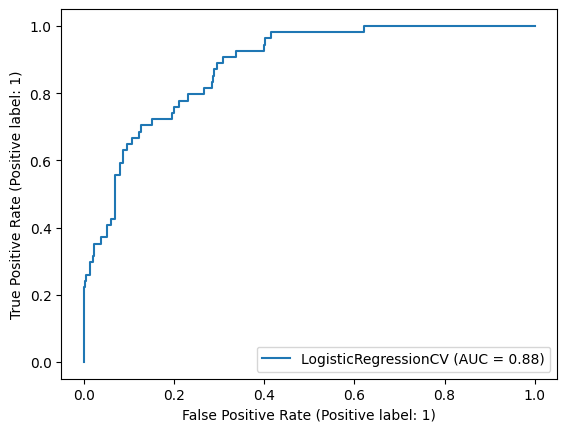

In [56]:
RocCurveDisplay.from_estimator(logistic_clf, X_test_scale, y_test);

**It's a very good result for such a simple model. Recall is too small, but by changing the threshold of the predictor, you can make it higher, if necessary**

# ***SVM***

**The type of kernel and the regularization coefficient will be selected according to the grid**

In [57]:
params = {'kernel': ['rbf', 'poly'], 'C': np.linspace(1e-3, 1e3, 20)}
svm_grid = GridSearchCV(SVC(), params, verbose=2, n_jobs=-1)

In [58]:
svm_grid.fit(X_train_scale, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 5.26325263e+01, 1.05264053e+02, 1.57895579e+02,
       2.10527105e+02, 2.63158632e+02, 3.15790158e+02, 3.68421684e+02,
       4.21053211e+02, 4.73684737e+02, 5.26316263e+02, 5.78947789e+02,
       6.31579316e+02, 6.84210842e+02, 7.36842368e+02, 7.89473895e+02,
       8.42105421e+02, 8.94736947e+02, 9.47368474e+02, 1.00000000e+03]),
                         'kernel': ['rbf', 'poly']},
             verbose=2)

**Let's look at the best parameters and the best score of estimators**

In [59]:
svm_grid.best_params_, svm_grid.best_score_

({'C': 52.63252631578947, 'kernel': 'rbf'}, 0.8799058577405858)

In [60]:
svm_clf = svm_grid.best_estimator_

**Result**

In [61]:
y_pred, y_pred_proba = svm_clf.predict(X_test_scale), svm_clf.decision_function(X_test_scale)
evaluate(y_test, y_pred, y_pred_proba)

accuracy: 0.9025         
precision: 0.7027027027027027         
recall: 0.48148148148148145         
roc-auc: 0.9287090558766858


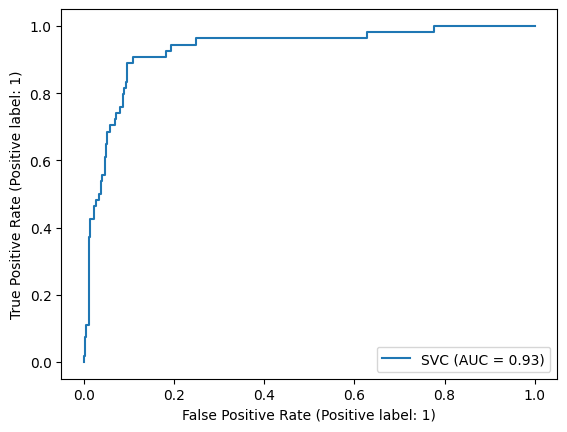

In [62]:
RocCurveDisplay.from_estimator(svm_clf, X_test_scale, y_test);

**About 5.6% better than LR, as measured by AUC. We also see a significant improvement in recall, albeit with a slight loss in precision.**

# **Random forest**

**To train the forest, we will use a fairly large grid of hyperparameters, so we use RandomizedSearch instead of GridSearch.**

In [67]:
params = {'n_estimators': range(3, 150, 5), 'max_depth': range(10, 50, 2), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(3, 60, 1)}
forest_grid = RandomizedSearchCV(RandomForestClassifier(), params, verbose=2, n_jobs=-1, n_iter=1000)

**It is not necessary to submit scaled data for training, because the scale of the data is not important for trees and scaling can only complicate training. The same is true for XGBoost**

In [68]:
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=1000, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(10, 50, 2),
                                        'min_samples_leaf': range(3, 60),
                                        'n_estimators': range(3, 150, 5)},
                   verbose=2)

**Let's look at the best parameters again**

In [69]:
forest_grid.best_params_

{'n_estimators': 68,
 'min_samples_leaf': 3,
 'max_depth': 36,
 'criterion': 'gini'}

In [70]:
forest_clf = forest_grid.best_estimator_

**And result is**

In [71]:
y_pred, y_pred_proba = forest_clf.predict(X_test), forest_clf.predict_proba(X_test)[:, 1]
evaluate(y_test, y_pred, y_pred_proba)

accuracy: 0.905         
precision: 0.7857142857142857         
recall: 0.4074074074074074         
roc-auc: 0.9470134874759152


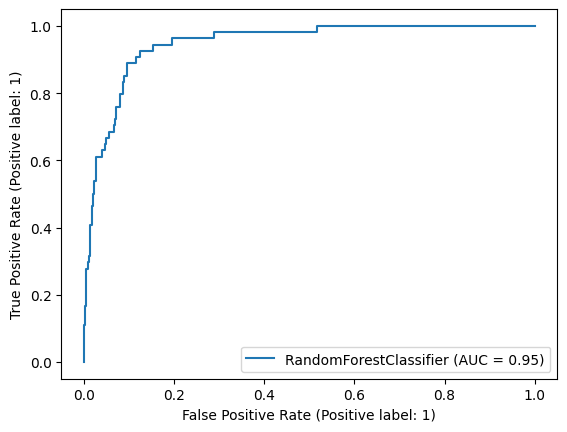

In [72]:
RocCurveDisplay.from_estimator(forest_clf, X_test, y_test);

**Although recall has become lower, in general, as expected, the ensemble model performs better and shows very good results.**

# **Gradient boosting(XGBoost)**

**Let's train one of the most powerful non-neural network models, gradient boosting over decision trees.**

In [73]:
params = {'n_estimators': range(2, 500, 100), 'max_depth': range(2, 20, 5), 'lambda': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]}

In [74]:
xg_clf = RandomizedSearchCV(XGBClassifier(min_child_weight=1), params, verbose=2, n_iter=10, n_jobs=-1)

In [75]:
xg_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None, min_child_weight=1,
                                           missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'lambda': [0.001, 0.01, 0.1, 1, 10.0,
                                                   100.0, 1000.0],
                                        'max_depth': range(2, 20, 5),
                                        'n_estimators': range(2, 500, 100)},
                   verbose=2)

In [76]:
xg_clf.best_params_

{'n_estimators': 302, 'max_depth': 7, 'lambda': 0.01}

In [77]:
y_pred, y_pred_proba = xg_clf.predict(X_test), xg_clf.predict_proba(X_test)[:, 1]
evaluate(y_test, y_pred, y_pred_proba)

accuracy: 0.9375         
precision: 0.8085106382978723         
recall: 0.7037037037037037         
roc-auc: 0.9424106187111967


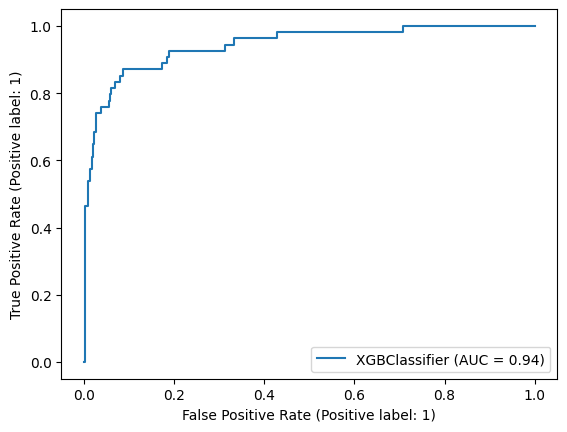

In [78]:
RocCurveDisplay.from_estimator(xg_clf.best_estimator_, X_test, y_test);

**Although the AUC boosting is slightly inferior to the random forest, it shows excellent quality in all other metrics. In addition, RandomizedSearch was used, which most likely does not produce the most optimal parameters.**

# **A bit of data analysis**

**Let's go back to our original dataset and look at the distribution of features depending on the class of objects.**

In [79]:
data.quality = (data.quality > 6.5).astype(int)

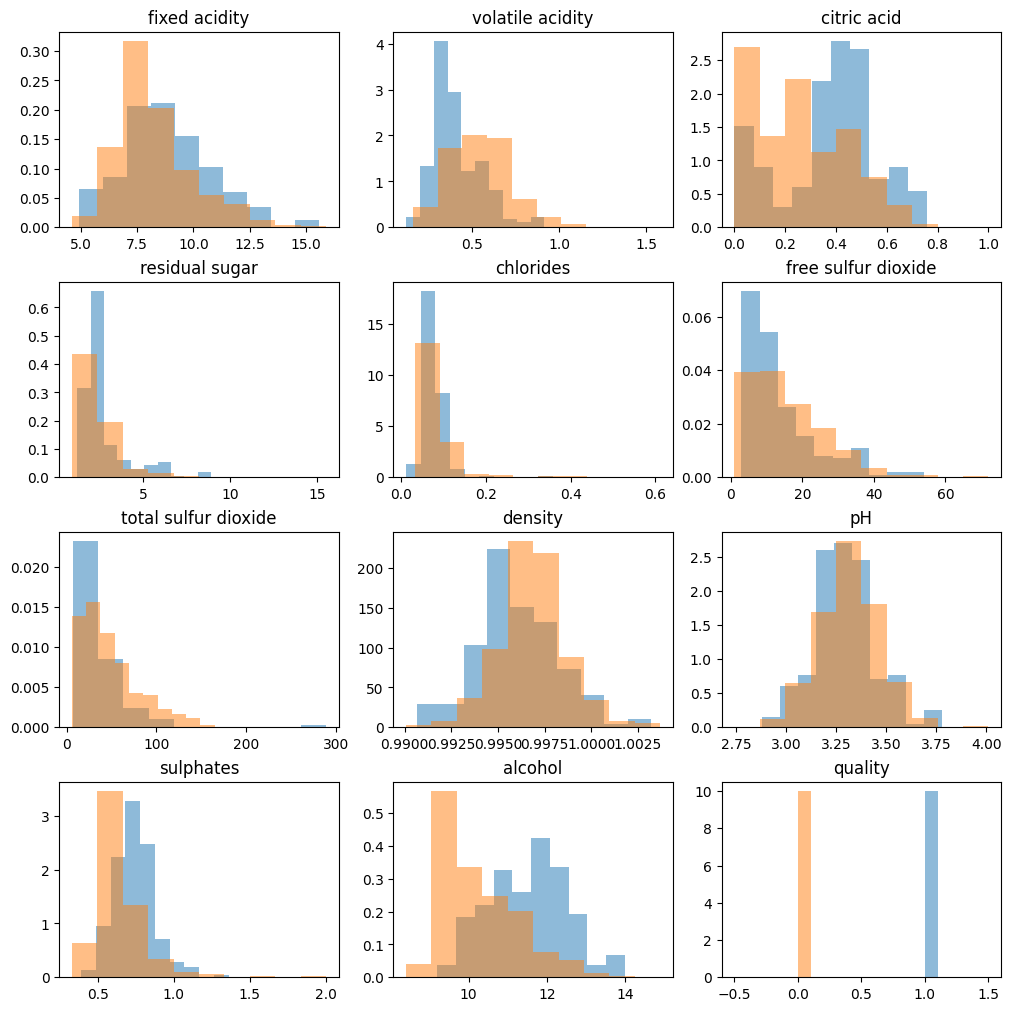

In [81]:
fig, ax = plt.subplots(4, 3, layout='constrained', figsize=(10, 10));
counter = 0
for row in range(4):
    for col in range(3):
        ax[row, col].hist(data[data.quality == 1][data.columns[counter]], density = True, alpha=0.5)
        ax[row, col].hist(data[data.quality == 0][data.columns[counter]], density = True, alpha=0.5)
        ax[row, col].set_title(data.columns[counter])
        counter += 1

**Here, blue is class 1 (good wine), orange is class 0 (bad wine). It's easy to see that certain features have an offset depending on the class. It is clearly visible on the charts of 'alcohol', 'sulphates', 'citric acid' and not so clearly on the chart of 'fixed acidity'. This suggests that these features are important for classification and you can try to train models using only them.**

# **Models on 'important' features**

**Preprocessing**

In [82]:
X_imp = data[['fixed acidity', 'citric acid', 'sulphates', 'alcohol']]

In [84]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_imp, y, stratify=y, shuffle=True)

In [86]:
# Сhecking that nothing was missed or mixed up.
y_train_2.sum(), y_test_2.sum(), y.sum()

(163, 54, 217)

In [87]:
scaler = StandardScaler()
X_train_scale_2 = scaler.fit_transform(X_train_2)
X_test_scale_2 = scaler.transform(X_test_2)

In [88]:
X_train_scale_2.shape, X_test_scale_2.shape

((1199, 4), (400, 4))

# **Random forest with only 'important' features**

In [89]:
params = {'n_estimators': range(3, 150, 5), 'max_depth': range(10, 50, 2), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(3, 60, 1)}
forest_grid = RandomizedSearchCV(RandomForestClassifier(), params, verbose=2, n_jobs=-1, n_iter=1000)

In [90]:
forest_grid.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=1000, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(10, 50, 2),
                                        'min_samples_leaf': range(3, 60),
                                        'n_estimators': range(3, 150, 5)},
                   verbose=2)

In [100]:
forest_grid.best_params_

{'n_estimators': 28,
 'min_samples_leaf': 3,
 'max_depth': 24,
 'criterion': 'entropy'}

In [101]:
forest_clf_2 = forest_grid.best_estimator_

In [106]:
y_pred, y_pred_proba = forest_clf_2.predict(X_test_2), forest_clf_2.predict_proba(X_test_2)[:, 1]
evaluate(y_test_2, y_pred, y_pred_proba)

accuracy: 0.895         
precision: 0.65         
recall: 0.48148148148148145         
roc-auc: 0.9018143866409762


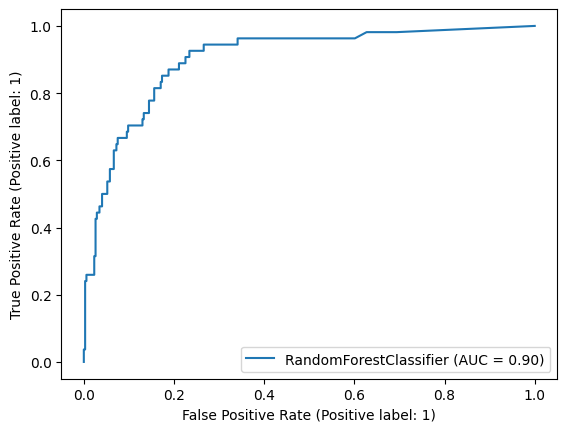

In [107]:
RocCurveDisplay.from_estimator(forest_clf_2, X_test_2, y_test_2);

**As we can see, the quality has dropped, though. But we use ONLY 4 FEATURES out of 11. Therefore, we can conclude that the bias in the distributions does have a significant impact on the classification result.**

# **XGBoost with only 'important' features**

In [108]:
params = {'n_estimators': range(2, 500, 100), 'max_depth': range(2, 20, 5), 'lambda': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]}

In [109]:
xg_clf = RandomizedSearchCV(XGBClassifier(min_child_weight=1), params, verbose=2, n_iter=10, n_jobs=-1)

In [110]:
xg_clf.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None, min_child_weight=1,
                                           missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'lambda': [0.001, 0.01, 0.1, 1, 10.0,
                                                   100.0, 1000.0],
                                        'max_depth': range(2, 20, 5),
                                        'n_estimators': range(2, 500, 100)},
                   verbose=2)

In [111]:
xg_clf.best_params_

{'n_estimators': 102, 'max_depth': 7, 'lambda': 0.001}

In [112]:
y_pred, y_pred_proba = xg_clf.predict(X_test_2), xg_clf.predict_proba(X_test_2)[:, 1]
evaluate(y_test_2, y_pred, y_pred_proba)

accuracy: 0.9025         
precision: 0.6530612244897959         
recall: 0.5925925925925926         
roc-auc: 0.9117426675230144


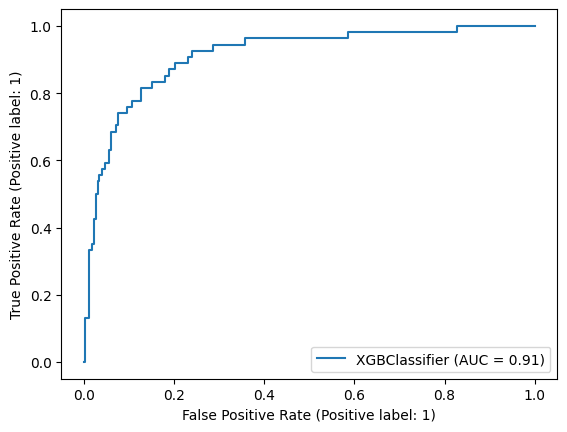

In [113]:
RocCurveDisplay.from_estimator(xg_clf.best_estimator_, X_test_2, y_test_2);

**The situation is similar with XGBoost**

# **Conclusion**

**We have trained several popular classification models and achieved a fairly high accuracy. At the same time, a rather superficial analysis of the data helped to identify important features in the data that strongly influence the classification result.**